**Installing libraries needed for the project**

In [119]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action = "ignore")

**Uploading the dataset and making it as a dataframe using pandas**

In [120]:
df = pd.read_csv("/content/diabetes (1).csv")

In [121]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [122]:
df.shape

(768, 9)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Data preprocessing by treating missing values,outliers**

In [124]:
#Replacing 0 with NULL to identify missing value

df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [125]:
#missing value statistics
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [126]:
#Replacing null values with median value
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [127]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [128]:
#To find which are the columns that has outliers
for feature in df:

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR

    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [129]:
#Treating the outliers
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]
threshold = np.sort(df_scores)[7]
outlier = df_scores > threshold
df = df[outlier]

In [130]:
#We see that the no.of rows is reduced as we have removed certain outliers
df.shape

(760, 9)

**Selecting relevant Features**

In [131]:
#new column NewBMI to give range for BMI like underweight,overweight etc

NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
df["NewBMI"] = NewBMI
df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

#new column NewInsulinScore to tell whether the insulin level is normal or abnormal

def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"
df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))


#new column NewGlucose to tell the level of glucose like normal,high etc
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [132]:
#The no.of columns has increased as we have new features to the dataframe
df.shape

(760, 12)

**Tranforming the dataset to work with model**

In [133]:
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [134]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [135]:
categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1


In [136]:
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [137]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [138]:
X = pd.concat([X,categorical_df], axis = 1)

**Training the model**

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model-1 : Multiple Linear Regressions**

In [140]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


In [141]:
test_acc_ = round(regressor.fit(X_train,y_train).score(X_test, y_test)* 100, 2)
train_acc_ = round(regressor.fit(X_train, y_train).score(X_train, y_train)* 100, 2)

<Axes: xlabel='Outcome', ylabel='Density'>

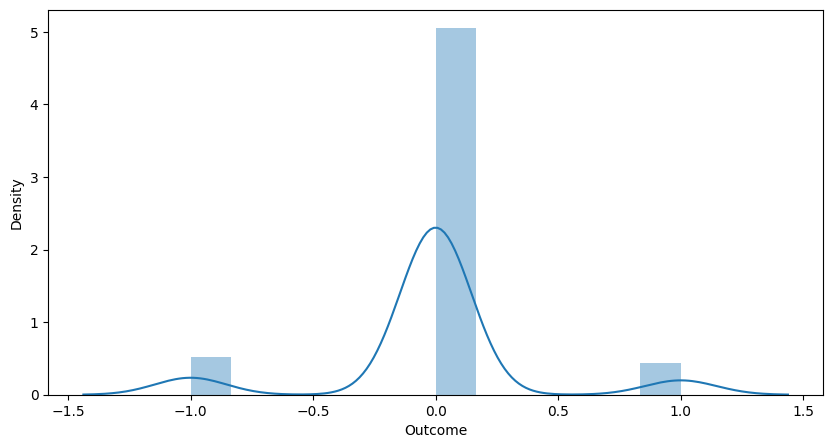

In [142]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)


In [143]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df1

,Actual,Predicted
400,1,0
329,0,0
98,0,0
504,0,0
111,1,1
506,1,0
286,0,1
617,0,0
700,0,1
588,1,1


In [144]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))


MAE: 0.15789473684210525
MSE: 0.15789473684210525
RMSE: 0.39735970711951313
VarScore: 0.32705447830101586


In [145]:
model = pd.DataFrame({
    'Model': ['Logiistic Regression'],
    'Train Score': [train_acc_],
    'Test Score': [test_acc_]
})
model.sort_values(by='Test Score', ascending=False)

,Model,Train Score,Test Score
0,Logiistic Regression,85.86,84.21


In [146]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.84


**Model 1: Multi Layer Perceptron**

In [147]:
from sklearn.neural_network import MLPClassifier

# We define the model
mlp = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

# We train model
mlp.fit(X_train, y_train)


# We predict target values
prediction = mlp.predict(X_test)

In [148]:
test_acc_mlp = round(mlp.fit(X_train,y_train).score(X_test, y_test)* 100, 2)
train_acc_mlp = round(mlp.fit(X_train, y_train).score(X_train, y_train)* 100, 2)

<Axes: xlabel='Outcome', ylabel='Density'>

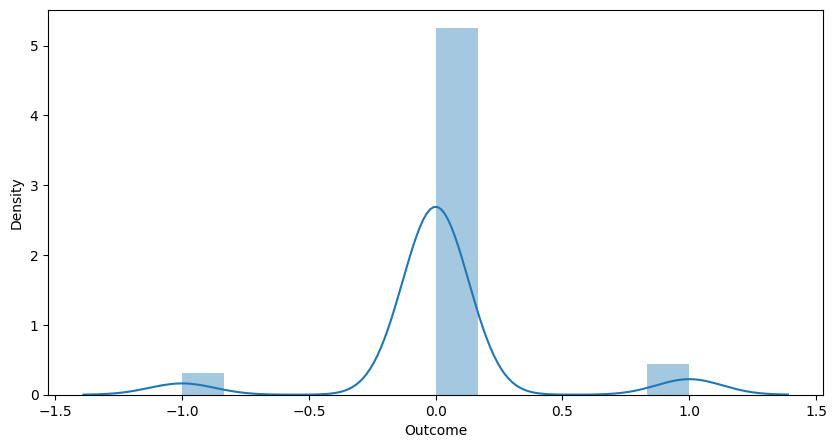

In [149]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test-prediction)
sns.distplot(residuals)

In [150]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
df1 = df.head(10)
df1

,Actual,Predicted
400,1,1
329,0,0
98,0,0
504,0,0
111,1,1
506,1,1
286,0,1
617,0,0
700,0,0
588,1,1


In [151]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))
print('VarScore:',metrics.explained_variance_score(y_test,prediction))

MAE: 0.125
MSE: 0.125
RMSE: 0.3535533905932738
VarScore: 0.46832871652816255


In [152]:
model1 = pd.DataFrame({
    'Model': ['MLP'],
    'Train Score': [train_acc_mlp],
    'Test Score': [test_acc_mlp]
})
model1.sort_values(by='Test Score', ascending=False)

,Model,Train Score,Test Score
0,MLP,93.75,87.5


In [153]:
accuracy = accuracy_score(y_test, prediction)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88
